<a href="https://colab.research.google.com/github/AnikaTha/Spotify_Data_Exploration/blob/main/FINAL_Submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction + Questions:

College students, including us, love listening to music! It helps us focus and gives everyone a break from all the studying, homework assignments, and projects.

Listeners love to find new music to help them de-stress and/or connect with others but it can be hard to find new music which users will actually enjoy. Users tend to listen to music of their liking and preference and Spotify generates characteristics for each song: danceability, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, and time signature.

URL to explain what these traits mean: https://developer.spotify.com/documentation/web-api/reference/get-audio-features URL for gdp per capita data: https://data.worldbank.org/indicator/NY.GDP.PCAP.CD

Our research went in two directions:

Using these characteristics, it is possible to come up with our own metrics, such as how happy or a song may be, by weighting these features differently. In addition, all of our group members acknowledge how usually the songs a person listens to reflects their own state of being. With these experiences and knowledge in mind, a question we asked ourselves is "can we tell how happy the residents of a country are based on the music they listen to?" In addition, can we find correlation between this happiness metric and other metrics such as GDP to determine whether money really does equal happiness?

In this increasingly globalized world we live in, can we still differentiate countries by the songs they listen to? When manually looking through countries' "Top 50" playlists, we found English music in the India playlist, and other similar cultural combinations. Will we find any other interesting similarities between what countries are listening to? More specificially, "Will we find unexpected countries in the same song clusters?"

## Part A: Happiness vs. GDP

In [ ]:
import pandas as pd
from google.colab import files
uploaded = files.upload()


Saving artists_cleaned.csv to artists_cleaned.csv


In [ ]:
import matplotlib.pyplot as plt

First, we read in the dataset we generated (code can be found in "Generate_Songs_CSV.ipynb"). This .csv contains the "Top 50" songs (as determined by Spotify" of various countries, along with features of these songs (described above).

In [ ]:
import io
df = pd.read_csv(io.BytesIO(uploaded['top_50_by_country.csv']))
df

KeyError: ignored

We grouped the csv by country, and aggregated using the mean in order to come up with one representative sample for each country. Then, we normalized the data to scale all of the features uniformly.

In [ ]:
#Normalize Data
quantData = df.drop(['mode', 'time_signature', 'id', 'Unnamed: 0'], axis = 1)
grouped = quantData.groupby('country')
grouped = grouped.aggregate('mean')
norm = (grouped - grouped.mean())/grouped.std()
norm

In [ ]:
from google.colab import files
upload = files.upload()

In [ ]:
import io
gdp = pd.read_csv(io.BytesIO(upload['gdp_per_capita.csv']))
gdp

Spotify’s generated characteristics can help identify a type of music genre. Looking at the characteristics, we’ve decided to analyze the “happiness” of countries’ top 50 songs average so users can explore music in a specific country based on their preference of happier, sadder, or songs somewhere in between.

We combined the generated characteristics of danceability, tempo, and energy, valence and liveliness in order to calculate the "happiness" of each country's representative song. We operated under the assumption that happier songs have a higher energy, danceability, tempo, liveliness, and valence. In addition, we are assuming that those who listen to happier music are themselves happier.

Our happiness metric was the average of the aforementioned metrics.


In [ ]:
happyTable = norm.drop(columns = ["acousticness", "duration_ms",
                               "instrumentalness", "key", "loudness",
                               "speechiness"]) #keep the energy, danceability, tempo, liveliness, and valence columns
happyTable["happiness"] = happyTable.sum(axis = 1, numeric_only = True)/5 #adding happiness metric as a column to the original table
happyTable = gdp.join(happyTable, on = gdp['Country Name'], how = 'right') #join happiness table with the gdp table in a one-to-one join
finalTable = pd.DataFrame()
finalTable['country'] = happyTable['Country Name']
finalTable['happiness'] = happyTable.happiness
finalTable['gdp'] = happyTable['2021']
finalTable = finalTable.reset_index()
finalTable

We then generated a histogram...

In [ ]:
axes = finalTable.happiness.plot.hist()

And a scatterplot with the happiness on one axis and the gdp on another.

In [ ]:
happyPlot = finalTable.plot.scatter(x = "happiness", y = "gdp", s = 100, figsize = (17, 17), colormap = plt.cm.coolwarm, c = finalTable.happiness, alpha = 0.75)
happyPlot.set_xlabel('Song Happiness')
happyPlot.set_ylabel('GDP per capita')
for (i, r) in finalTable.iterrows():
  happyPlot.text(x = r.happiness, y = r.gdp, s = r.country)

# Part A Analysis

There are several interesting trends we can observe when looking at the correlation of happiness found in the top 50 songs of a country and their gdp per capita. In some cases, gdp per capita is used as a measure of the wellbeing of the population of a country as it is a measure of how the wealth of a country is spread among its population. We wanted to see if song happiness could also be used as a measure and correlate with the gdp measure.

According to the graph, the countries with a low gdp per capita have songs that are pretty spread out on the happiness scale. We observe that Brazil has one of the lower GDP per capita, but ranks the highest on the happiness scale in terms of its music. Most of the countries with higher gdp per capitas rank in the middle of the happiness scale, not on either extremes. This can be observed with Luxembourg and Ireland which are close to zero on the scale of happiness, but have pretty high gdp per capitas.

Maybe money cannot buy happiness or at least make you listen to happier songs.

#Part B: Finding Countries with Similar songs using PCA and KMeans clustering

Another interpretation of this Spotify data is finding music similar to one's own countries’ top 50 songs. Using a graph, we plan to cluster countries based on their similarities of danceability, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, and time signature characteristics which was given from Spotify data. Clustering countries allows countries to be put in groups of their similarities and it is easier to check out music in a single cluster first before branching out to another cluster group.

In [ ]:
#elbow method of calculations was used to determine that there should be around 10 clusters
#KMeans was used to determine which countries belong in what clusters based on their quantitative factors from the normalized data
import sklearn.cluster
import pandas
km = sklearn.cluster.KMeans(n_clusters = 10)
cluster_table = km.fit_predict(norm)
cluster_table = pandas.DataFrame(cluster_table, columns = ['clusters'], index = norm.index)
cluster_table

In [ ]:
#running PCA on the normalized data to reduce its dimensions
import sklearn.decomposition as sk
pca = sk.PCA()
PCA = pca.fit_transform(norm)
PCA = pandas.DataFrame(PCA, index = norm.index)
PCA

In [ ]:
#plot of the 2D data colored by what cluster it is in and labeled with the country
import matplotlib.pyplot as plt
ax = PCA.plot.scatter(x=0, y=1, figsize = (40, 30), colormap = plt.cm.rainbow, c = cluster_table.clusters, s = 500, alpha = 0.5)
for (i, r) in PCA.iterrows():
    ax.text(x = r[0] + 0.03, y = r[1] + 0.03, s = i, fontsize = 20)

# Part B Analysis

Our attempt with this graph was to show which countries have similar music. We did this by analyzing the quantitative metrics that Spotify provided about each song in a country's top 50. We did this by keeping the factors, acousticness, danceability, duration, energy, instrumentalness, key, liveness, loudness, speechiness, tempo, and valence. We then grouped the data for each song by the country it was in and normalized it. Next we found the clusters in which the countries belonged (which countries were the most similar to each other). Finally, we reduced the dimensionality of the data to 2D as there were many initial columns taken into account, and plotted the data.

Some things that interesting when examining the graph is that countries in Southeast Asia (Malaysia, Vietnam, China, India, etc.) are in one cluster, indicating that they have similar music. The same pattern can be observed with countries in Spanish speaking countries like Spain, Colombia, Chile, Uruguay and more. Similarly, all of the English speaking countries are also closeby. This can indicate that music is similar across regions. This can be due to either lingustic or cultural similarities.

## Conclusion

Based on the chosen metrics such as GDP and happiness, it can be visualized from the provided graphs that there isn't a strong correlation between Spotify users in a given country listening to happy songs and the country's gdp (Graph 1). For example, Brazil has the greatest song happiness of all the surveyed countries, however it has one of the lowest GDP’s on the scale. Whereas, Luxembourg has the highest GDP, and an average level of song happiness. This shows that GDP is not an indicator of the level of happiness in a country.

Additionally, countries of close proximity and linguistic backgrounds seem to listen to music with shared characteristics (Graph 2). For example, India, China, Philippines, Vietnam, Malaysia, Indonesia, and Iceland share a cluster in Graph 2. Six out of these seven countries are close in geographical proximity which could account towards a liking of similar music styles because of cultural similarities. This is shown as the same with people in predominantly Spanish speaking and English speaking countries.

Keep in mind that there are limitation to our data analysis because the generated data from Spotify where it creates a scale for danceability, energy, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo, duration_ms, and time signature was scaled by a computer using artificial intelligence and it may not be fully accurate with how each characteristic is portrayed in each song. The human that created the scale for the characteristics could also have bias about songs which skew the definitions for the characteristics altering the “happiness” of the song.


After analyzing the happiness of songs in each country versus the GDP of each country, more questions about the happiness of each country arise. How did the pandemic affect the happiness of each countries’ top 50 songs? Do economic crises affect songs produced in a country?


# Part 3
# **Question**

Music is something that many of us love to listen to on a daily basis for entertainment, expressing our feelings, connecting with others, and more. To get song recommendations or trending songs, listeners can choose to turn to the Spotify Top 50 for a given country. Specifically with the songs, users can look at artists’ and the genres associated with certain songs to find music best catered to them.

Dataset used for this part: https://www.kaggle.com/datasets/pieca111/music-artists-popularity

This dataset contains a table with artists, the country they are associated with, along with tags that are associated with them. There are around 160 countries represented.

From our previous iteration of the data science project, we felt like investigating the nature of the music further. In particular, we wanted to see if people's perceptions of music matched the more "concrete" values generated by the Spotify API. Our further analysis went in the following directions:

*   We wanted to group data of each country to show key tags associated with music
characteristics of each country to answer “What are some of the most relevant keywords and their frequency in a country’s top 50 playlist?” A visual representation of this is also shown with the word cloud.
*   We wanted to compare country relationships in another way by using a distance matrix to group countries that are similar with various characteristics. We wanted to find out “What countries are most similar to each other in terms of key characteristics” such as genre, artists, etc.







Computing TFIDF for the genres labels for the artists of each country with a new dataset (artists). The data set cotains the artists, the genres they are associated with, and the country they are from

In [ ]:
import pandas as pd
from google.colab import files
import io
import numpy

In [ ]:
uploaded = files.upload()

Saving artists_cleaned.csv to artists_cleaned (1).csv


In [ ]:
#artists_cleaned.csv is a data set that contains popular artists,
#genres that their music is best described as and their country of origin
data = pd.read_csv(io.BytesIO(uploaded['artists_cleaned.csv']))
data

,Unnamed: 0,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist
0,0,cc197bad-dc9c-440d-a5b5-d52ba2e14234,Coldplay,Coldplay,United Kingdom,United Kingdom,rock; pop; alternative rock; british; uk; brit...,rock; alternative; britpop; alternative rock; ...,5381567.0,360111850.0,False
1,1,a74b1b7f-71a5-4011-9441-d0b5e4122711,Radiohead,Radiohead,United Kingdom,United Kingdom,rock; electronic; alternative rock; british; g...,alternative; alternative rock; rock; indie; el...,4732528.0,499548797.0,False
2,2,8bfac288-ccc5-448d-9573-c33ea2aa5c30,Red Hot Chili Peppers,Red Hot Chili Peppers,United States,United States,rock; alternative rock; 80s; 90s; rap; metal; ...,rock; alternative rock; alternative; Funk Rock...,4620835.0,293784041.0,False
3,3,73e5e69d-3554-40d8-8516-00cb38737a1c,Rihanna,Rihanna,United States,Barbados; United States,pop; dance; hip hop; reggae; contemporary r b;...,pop; rnb; female vocalists; dance; Hip-Hop; Ri...,4558193.0,199248986.0,False
4,4,b95ce3ff-3d05-4e87-9e01-c97b66af13d4,Eminem,Eminem,United States,United States,turkish; rap; american; hip-hop; hip hop; hiph...,rap; Hip-Hop; Eminem; hip hop; pop; american; ...,4517997.0,199507511.0,False
...,...,...,...,...,...,...,...,...,...,...,...
64929,985848,7330c7e3-92a3-41ec-9e9a-54b504eb6e34,あぁ!,あぁ!,Japan,NaN,japanese; hello project; j-pop; hello project ...,Hello Project; j-pop; idol,0.0,0.0,False
64930,985886,5276498e-1f61-458e-8d25-13d7378ed0b5,アップアップガールズ（仮）,アップアップガールズ（仮）,Japan,Japan,n; つんく♂プロデュース; ufw,japanese; JPop; idol,0.0,0.0,False
64931,986084,5efaf9af-0c14-4935-b00c-f11890711513,ヴィドール,ヴィドール,Japan,Germany; Japan,rock,visual kei; J-rock; japanese; jrock; Under Cod...,0.0,0.0,False
64932,986316,71f3b410-cd33-44a9-8adb-3f5461c00870,Butterfly Girls Band,彩蝶女乐,China,NaN,n2,seen live,0.0,0.0,False


In [ ]:
# we delete rows where the genres are NaN, becuase that is the data we are analyzing
valid_df = data[data['tags_mb'].notna()]
valid_df = valid_df[valid_df['tags_lastfm'].notna()]

valid_df["tags"] = valid_df["tags_mb"] + "; " + valid_df["tags_lastfm"]
valid_df.tail()

,Unnamed: 0,mbid,artist_mb,artist_lastfm,country_mb,country_lastfm,tags_mb,tags_lastfm,listeners_lastfm,scrobbles_lastfm,ambiguous_artist,tags
64929,985848,7330c7e3-92a3-41ec-9e9a-54b504eb6e34,あぁ!,あぁ!,Japan,NaN,japanese; hello project; j-pop; hello project ...,Hello Project; j-pop; idol,0.0,0.0,False,japanese; hello project; j-pop; hello project ...
64930,985886,5276498e-1f61-458e-8d25-13d7378ed0b5,アップアップガールズ（仮）,アップアップガールズ（仮）,Japan,Japan,n; つんく♂プロデュース; ufw,japanese; JPop; idol,0.0,0.0,False,n; つんく♂プロデュース; ufw; japanese; JPop; idol
64931,986084,5efaf9af-0c14-4935-b00c-f11890711513,ヴィドール,ヴィドール,Japan,Germany; Japan,rock,visual kei; J-rock; japanese; jrock; Under Cod...,0.0,0.0,False,rock; visual kei; J-rock; japanese; jrock; Und...
64932,986316,71f3b410-cd33-44a9-8adb-3f5461c00870,Butterfly Girls Band,彩蝶女乐,China,NaN,n2,seen live,0.0,0.0,False,n2; seen live
64933,986565,5700d876-fb3f-46b4-a459-5f3e5a069008,胡彦斌,胡彦斌,China,NaN,chinese; mandarin,C-pop; r&b; singer I appreciate,0.0,0.0,False,chinese; mandarin; C-pop; r&b; singer I apprec...


In [ ]:
# grouping the data by country of origin/country of association
g = valid_df.groupby('country_mb')

docs = g.tags.aggregate("; ".join)
docs = docs.map(lambda x: x.split('; '))
# keep countries with at least 5 tags
docs = docs[docs.map(len) > 5]
docs

country_mb
Afghanistan    [production music, arabic, ethnic, percussion,...
Albania        [hip hop, rapper, albania, rock n roll, covers...
Algeria        [french, arabic, world, algerian, raï, north a...
Angola         [folk, music of angola, semba, angola, african...
Anguilla       [rock, pop, new wave, Canadian, 80s, female vo...
                                     ...                        
Vietnam        [has german audiobooks, buddhist, Love, speech...
Yemen          [sillyname, witch house, electronic, experimen...
Yugoslavia     [rock, hard rock, rock, balkan, ex-yu, Bosnian...
Zambia         [psychedelic rock, acid rock, zamrock, Psyched...
Zimbabwe       [mbira, zimbabwe, african, female vocalists, a...
Name: tags, Length: 161, dtype: object

In [ ]:
#creating the bag of words model
#counts the frequency of each genre word based on the country
TF = docs.apply(lambda bag: pd.Series(bag).value_counts())
TF

,production music,arabic,ethnic,percussion,Oriental,middle east,under 2000 listeners,rock,Albanian,albania,...,Dreamtwinz,jit,zig zag world,manou gallo,shona,JL,african female vocalist,chiwoniso,gnarls barkley,john peel favorites
country_mb,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,52.0,8.0,1.0,10.0,2.0,4.0,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yugoslavia,NaN,NaN,NaN,2.0,1.0,NaN,3.0,20.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#counts the total number of times each genre word appears
DF = TF.count()
DF

production music           40
arabic                     46
ethnic                     93
percussion                 53
Oriental                   48
                           ..
JL                          1
african female vocalist     1
chiwoniso                   1
gnarls barkley              1
john peel favorites         1
Length: 173488, dtype: int64

In [ ]:
#computes the IDF using the formula
IDF = numpy.log(len(TF)/DF)
IDF

production music           1.392525
arabic                     1.252763
ethnic                     0.548805
percussion                 1.111112
Oriental                   1.210203
                             ...   
JL                         5.081404
african female vocalist    5.081404
chiwoniso                  5.081404
gnarls barkley             5.081404
john peel favorites        5.081404
Length: 173488, dtype: float64

In [ ]:
#computes the TFIDF matrix which downvotes the most common words
#and measures how often a words appears in the document
TFIDF = TF*IDF
TFIDF

,production music,arabic,ethnic,percussion,Oriental,middle east,under 2000 listeners,rock,Albanian,albania,...,Dreamtwinz,jit,zig zag world,manou gallo,shona,JL,african female vocalist,chiwoniso,gnarls barkley,john peel favorites
country_mb,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1.392525,1.252763,0.548805,1.111112,1.210203,2.085672,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Albania,NaN,NaN,NaN,NaN,NaN,NaN,1.671861,0.932159,8.050527,6.003926,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Algeria,NaN,65.143674,4.390439,1.111112,12.102034,4.171344,1.671861,1.242879,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angola,NaN,NaN,0.548805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anguilla,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.621439,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,NaN,NaN,NaN,NaN,NaN,NaN,2.089826,0.932159,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yugoslavia,NaN,NaN,NaN,2.222225,1.210203,NaN,1.253896,6.214395,2.683509,3.001963,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#calculating the document magnitudes on the genres listed in each country
docmags = (TFIDF**2).sum(axis=1)**0.5
docmags

country_mb
Afghanistan      3.295287
Albania         33.147885
Algeria        212.902497
Angola          30.308195
Anguilla        16.250255
                  ...    
Vietnam         63.547794
Yemen           17.345814
Yugoslavia     170.151707
Zambia          23.635838
Zimbabwe        44.181297
Length: 161, dtype: float64

In [ ]:
#dividing the TFIDF rows by the document magnitude
#preparing to find the cosine
nTFIDF = TFIDF.divide(docmags, axis = 0)
nTFIDF = nTFIDF.fillna(0.0)
nTFIDF

,production music,arabic,ethnic,percussion,Oriental,middle east,under 2000 listeners,rock,Albanian,albania,...,Dreamtwinz,jit,zig zag world,manou gallo,shona,JL,african female vocalist,chiwoniso,gnarls barkley,john peel favorites
country_mb,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.422581,0.380168,0.166542,0.337182,0.367253,0.632926,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Albania,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050436,0.028121,0.242867,0.181125,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Algeria,0.000000,0.305979,0.020622,0.005219,0.056843,0.019593,0.007853,0.005838,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Angola,0.000000,0.000000,0.018107,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Anguilla,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038242,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.032886,0.014669,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Yemen,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Yugoslavia,0.000000,0.000000,0.000000,0.013060,0.007112,0.000000,0.007369,0.036523,0.015771,0.017643,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
#a table that shows how similar each country is to every other country, essentially a distance matrix
#it does this by finding the cosine similarity
cossim = nTFIDF.dot(nTFIDF.transpose())
numpy.fill_diagonal(cossim.values, 0)
cossim

country_mb,Afghanistan,Albania,Algeria,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,Yemen,Yugoslavia,Zambia,Zimbabwe
country_mb,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.000000,0.000000,0.154794,0.003016,0.000000,0.0,0.000946,0.011153,0.004327,0.007140,...,0.011861,0.002550,0.051153,0.000000,0.000560,0.000000,0.000000,0.007016,0.000000,0.012617
Albania,0.000000,0.000000,0.003069,0.000716,0.006795,0.0,0.010458,0.006597,0.019974,0.009156,...,0.040606,0.004125,0.000674,0.000212,0.003149,0.002966,0.000000,0.023057,0.001896,0.001738
Algeria,0.154794,0.003069,0.000000,0.016588,0.002954,0.0,0.021300,0.016272,0.015417,0.009769,...,0.034354,0.008040,0.049361,0.000215,0.007751,0.002522,0.001358,0.006698,0.011205,0.034460
Angola,0.003016,0.000716,0.016588,0.000000,0.003466,0.0,0.013235,0.002846,0.007877,0.004495,...,0.021016,0.009424,0.009182,0.000116,0.011227,0.000913,0.000155,0.001267,0.006824,0.036002
Anguilla,0.000000,0.006795,0.002954,0.003466,0.000000,0.0,0.018864,0.007108,0.036166,0.014643,...,0.063487,0.007684,0.005162,0.000000,0.004460,0.003716,0.000515,0.020077,0.001258,0.003256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,0.000000,0.002966,0.002522,0.000913,0.003716,0.0,0.004537,0.005247,0.009820,0.007989,...,0.018304,0.002770,0.005099,0.000110,0.002534,0.000000,0.003539,0.002452,0.001185,0.001515
Yemen,0.000000,0.000000,0.001358,0.000155,0.000515,0.0,0.006133,0.002926,0.016372,0.010432,...,0.036661,0.003741,0.003115,0.000000,0.004485,0.003539,0.000000,0.004949,0.001572,0.000000
Yugoslavia,0.007016,0.023057,0.006698,0.001267,0.020077,0.0,0.020662,0.005912,0.047019,0.026698,...,0.080835,0.008410,0.005296,0.001110,0.013017,0.002452,0.004949,0.000000,0.002653,0.002545


In [ ]:
cossim.idxmax() # what country is every other country most similar to?

country_mb
Afghanistan                               Egypt
Albania                                 Ireland
Algeria                                 Morocco
Angola         Democratic Republic of the Congo
Anguilla                                 Canada
                             ...               
Vietnam                                   Japan
Yemen                             United States
Yugoslavia                               Serbia
Zambia                                  Nigeria
Zimbabwe                           South Africa
Length: 161, dtype: object

Graph Visualization for how similar the countries are based on the genres of the music from the artists of the countries

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
#calculating the adjacency matrix
#the cossim similarities between the countries are greater than .18
adjacency = cossim.applymap(lambda v: v >= 0.18)
adjacency = adjacency.loc[adjacency.any(axis = 1)]
adjacency

country_mb,Afghanistan,Albania,Algeria,Angola,Anguilla,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United States,Uruguay,Uzbekistan,Vatican City,Venezuela,Vietnam,Yemen,Yugoslavia,Zambia,Zimbabwe
country_mb,,,,,,,,,,,,,,,,,,,,,
Afghanistan,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Algeria,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Anguilla,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Argentina,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
Australia,False,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
United Kingdom,False,False,False,False,False,False,False,False,True,False,...,True,False,False,False,False,False,False,False,False,False
United States,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
Uruguay,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
#creating a graph from the cossim similarities
import networkx
graph = networkx.from_pandas_adjacency(adjacency)
graph

In [ ]:
graph.number_of_nodes(), graph.number_of_edges()

(69, 68)

In [ ]:
networkx.to_pandas_edgelist(graph)

,source,target,weight
0,Afghanistan,Egypt,True
1,Algeria,Egypt,True
2,Algeria,Morocco,True
3,Algeria,Tunisia,True
4,Anguilla,Canada,True
...,...,...,...
63,South Sudan,Sudan,True
64,Spain,United States,True
65,Sweden,United States,True
66,Switzerland,United States,True


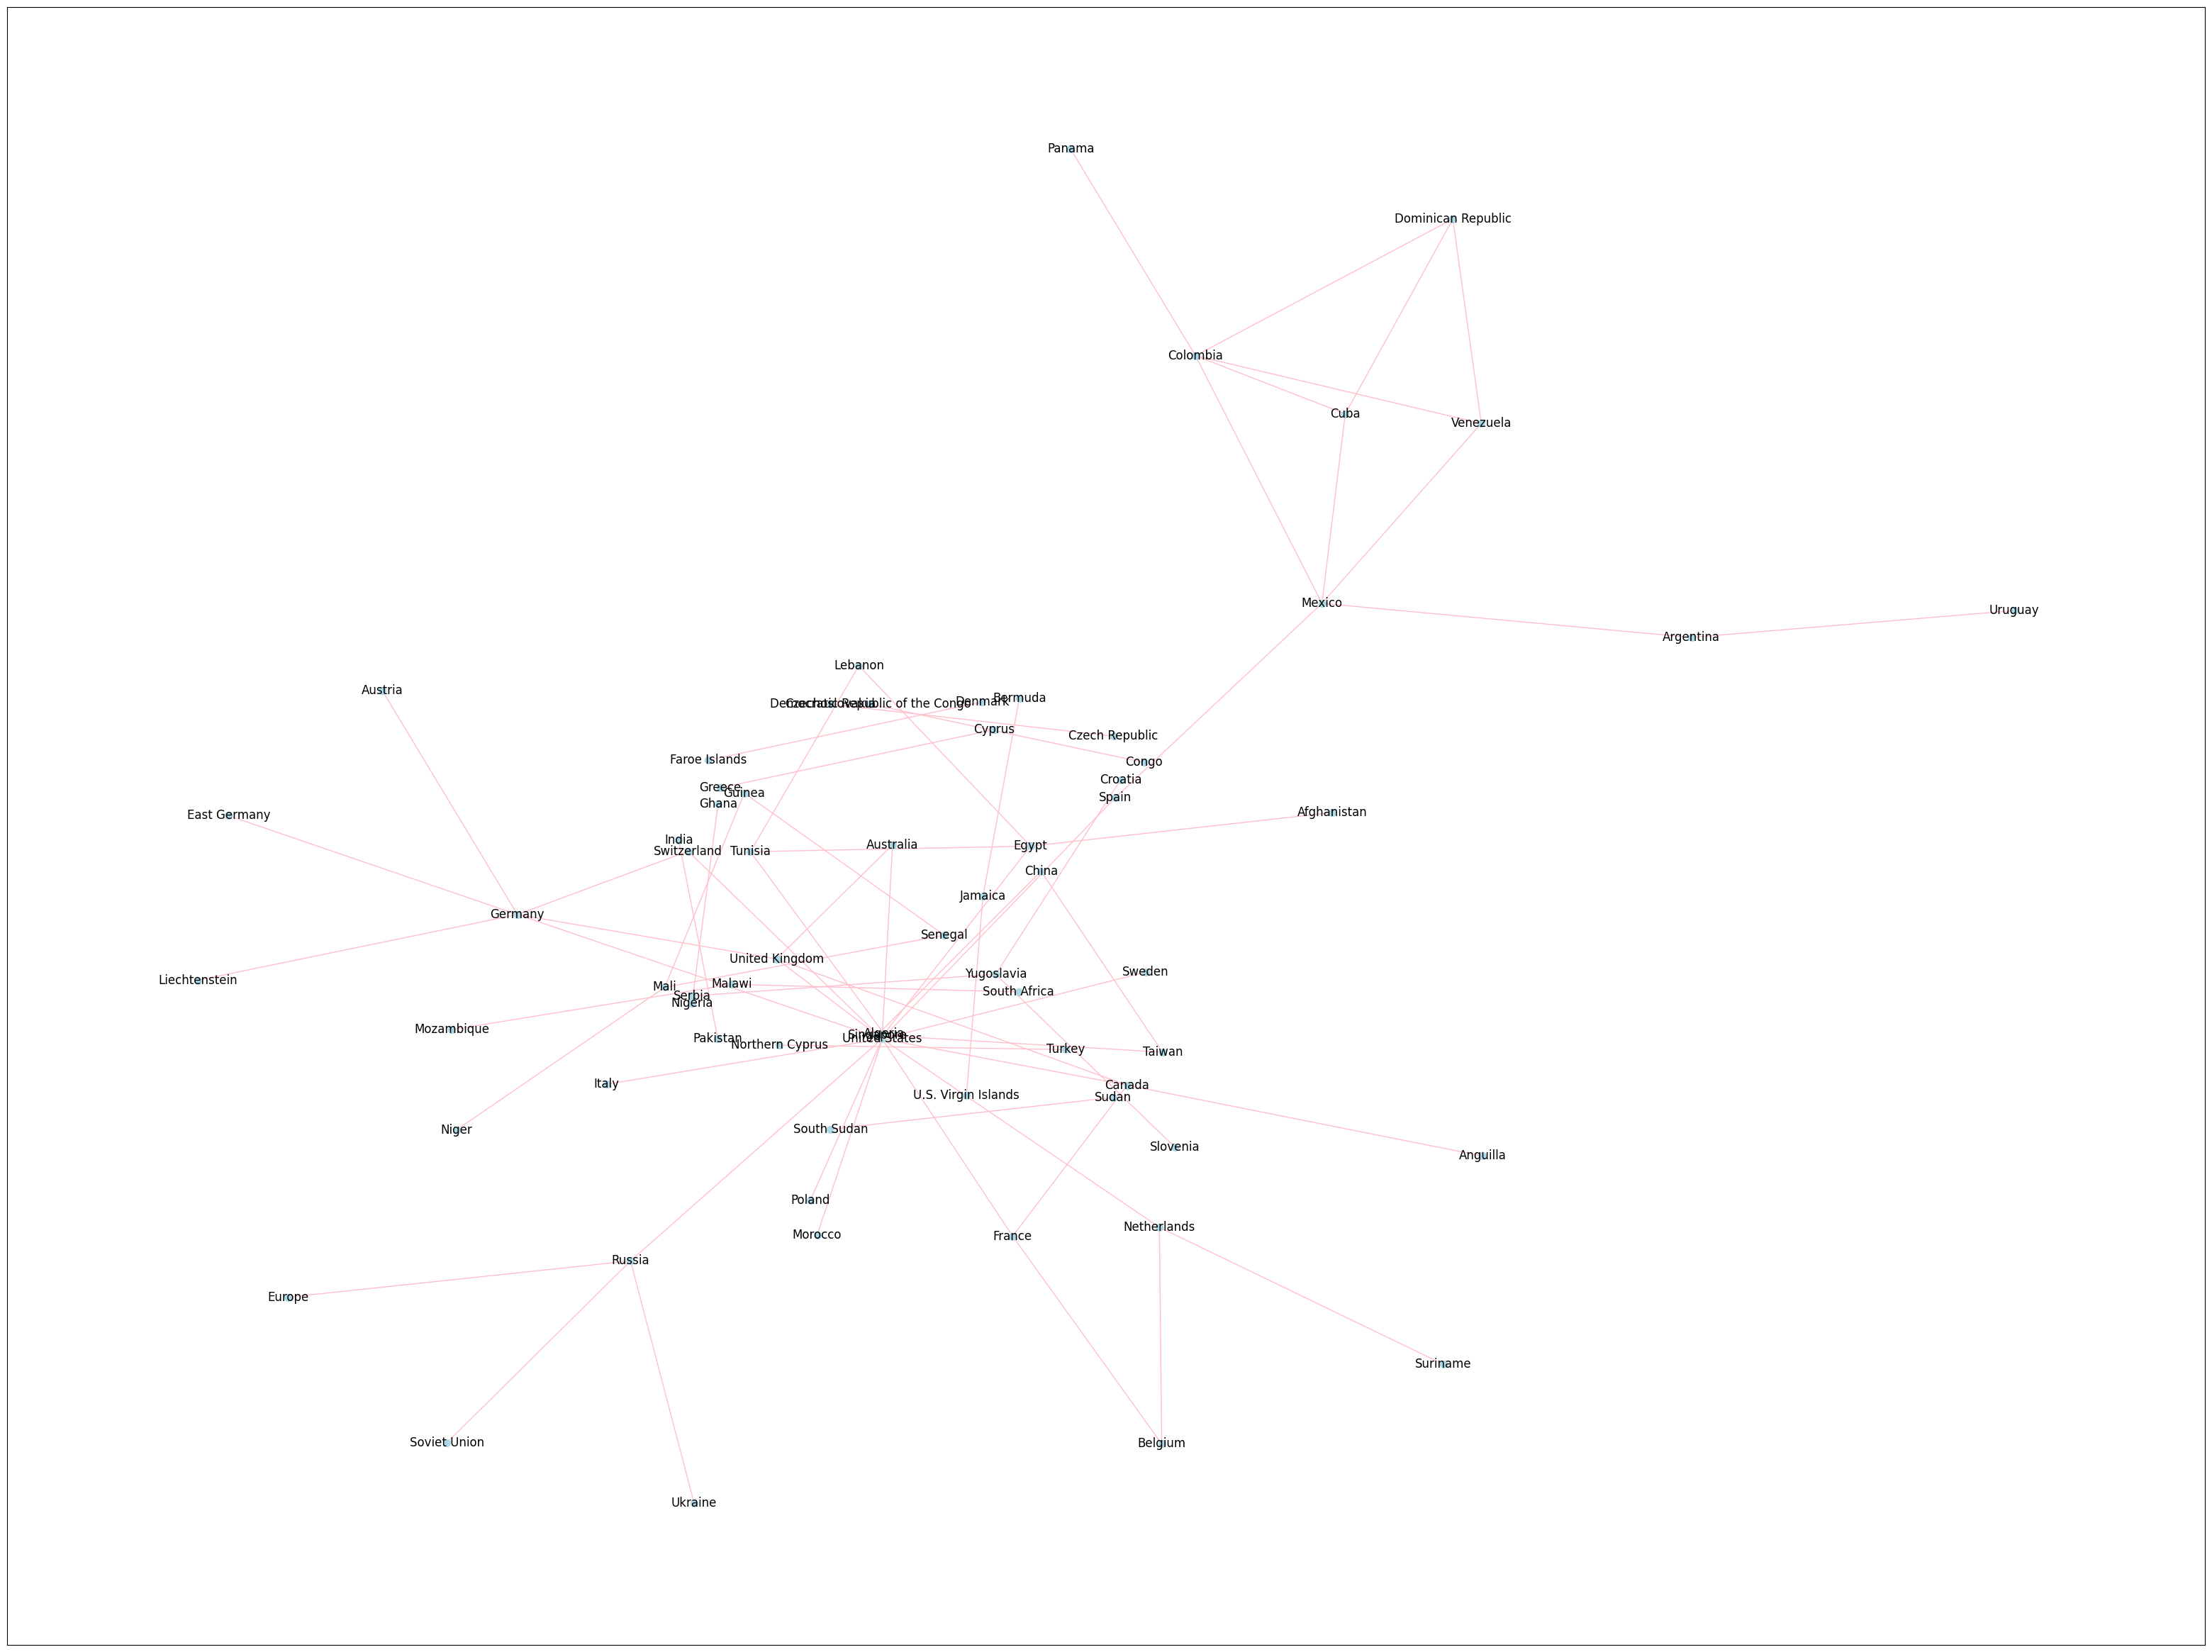

In [ ]:
layout = networkx.layout.kamada_kawai_layout(graph)
import matplotlib.pyplot
matplotlib.pyplot.figure(figsize=(40,30))
networkx.draw_networkx(graph, pos=layout, with_labels=True, node_color="lightblue", edge_color="pink", node_size = 50)

# Graph Analysis
The drawing that is produced here shows the countries that are most similar to each other based on what type of genres their artists make music in. The most noticeable patterns here is that some countries that are geographically close to each other also make similar genres of music. For example, Panama, Dominican Republic, Colombia, Cuba, Venezuela, Mexico, Argentina, and Uruguay all exist in Latin America. Further, it seems like their music genres are also similar as they all exist in proximity to each other. Similarly, this can also be seen with the countries next to Germany and even Egypt. Although, exceptions to this pattern exists, these are some notable trends within the graph.

This graph can also be compared to the part B graph we created in our previous iteration. Graph B compares the metrics from each of the top songs from different countries and creates clusters with other countries that are similar. We see the same types of trends between the 2 graphs, which is countries that are geographically closer with similar cultures tend to have similar music.

# Word Cloud by Country

In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['artists_cleaned.csv']))
df = df[~df['country_mb'].isna()]

In [ ]:
# creates a bag of all the countries in the data
countriesBag = list(set(df['country_mb']))
countriesBag = countriesBag[1:]
countriesBag.sort()

In [ ]:
import ipywidgets as widgets

# creates the radio button widget for the user to select a country
button = widgets.RadioButtons(options= countriesBag, description='Country:', disabled=False)
display(button)

def on_value_change(event):
    on_value_change.event = event
    print(event.new)

# the country is chosen on click
button.observe(on_value_change, names='value')

RadioButtons(description='Country:', options=('Afghanistan', 'Albania', 'Algeria', 'Angola', 'Anguilla', 'Anti…

India
United States


In [ ]:
# displays the country selected
country = on_value_change.event['new']
country

'United States'

In [ ]:
# counts the number of times a music style listed within the chosen country
tagBag = df.dropna()
tagBag['tags'] = tagBag.tags_mb.map(lambda b: b.split(';'))
g = tagBag.groupby('country_mb')
tagList = g.tags.aggregate(lambda SeriesOfBags: [w for tagBag in SeriesOfBags.values for w in tagBag])
tagList = [i.strip() for i in list(tagList[country])]
tagList
tagSet = list(set(tagList))
counts = [(tagList.count(w), w) for w in tagSet]

<ipython-input-29-e79d942a6bbb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tagBag['tags'] = tagBag.tags_mb.map(lambda b: b.split(';'))


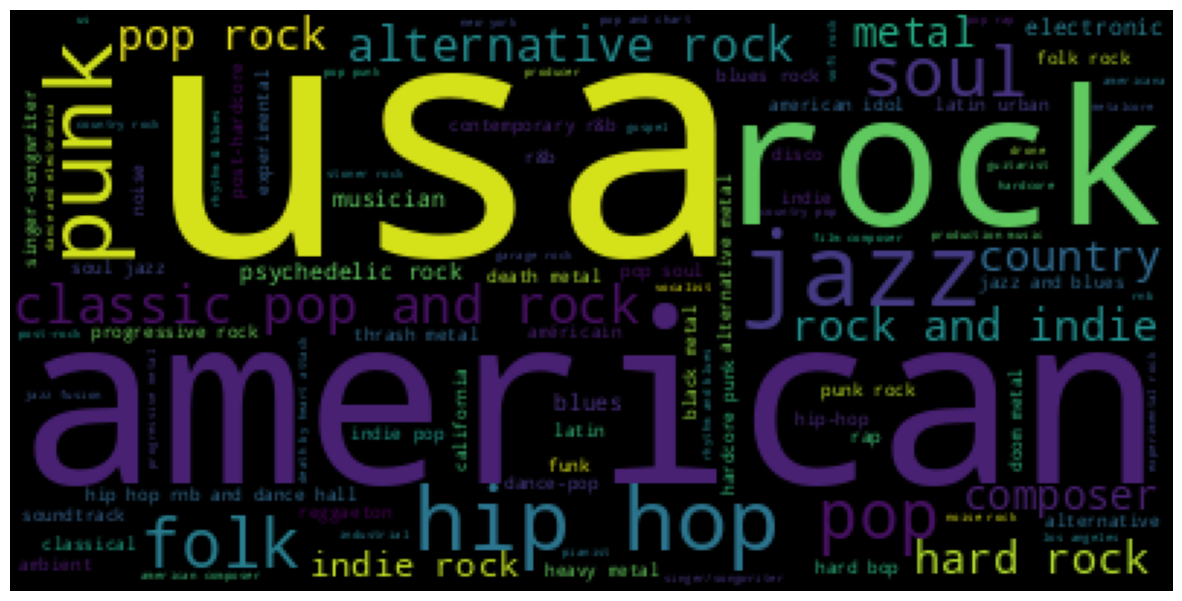

In [ ]:
import wordcloud
import matplotlib.pyplot as plt

# forms the word cloud
wc = wordcloud.WordCloud().generate_from_frequencies(dict([(w,f) for (f,w) in counts]))
fig = plt.figure(figsize=(15, 10))
p = plt.imshow(wc).axes.axis("off")

#Word Cloud Analysis
From this word cloud we can observe the descriptors of the most popular music styles in a country. The more popular music styles of the chosen country are displayed in larger fonts, whereas the less prominent music styles are shown in smaller fonts. In Part 2 of our project we concluded that countries close in proximity, such as Malaysia and China, had similar styles of music because of linguistic or cultural similarities through a cluster analysis. From the Malaysia and China word clouds, we can see that they do share similar music styles. Many major music styles overlap between these two countries. For example, some popular music styles that China and Malaysia share include black metal, chinese, rock, pop, punk, and mandarin. Therefore, from our cluster analysis in Part 2 and from the word cloud analysis we can conclude that countries close in proximity share similar music styles.

# Conclusion

After visualizing our dataset, you can find the most relevant keywords to each country when you click on the specific country and print out a word cloud. The word cloud helps the user know more about the music in a specific country from popular artists. Then we found out the similarities between countries based on the adjacent matrix. You can find countries which are similar to each other on the world map and have similar music, which can be justified because of similar cultures and languages between close proximity countries. And it is interesting to see the United States in the middle of the graph, meaning it has lots of connections to other countries, because of how diverse the United States is. This can help users find similar music to what they enjoy by exploring music in the country which is close to it on the map.

With our findings, there are limitations to our data because it only includes countries that have popular artists so the entire variety in a country is not fully observed. As well as bias in “popular artists” because not everyone enjoys a popular artists’ music, just the majority in that specific country so users can find it hard to explore music they enjoy. Another limitation to our findings is the time period of the popular artists, as time goes on, artists will leave and more will arise.

After clustering countries based on music, more questions about the similarities of each country arise. If we look back at past centuries, will the clusters be the same? Are countries better connected after the increased use of communication and shareability of music to other countries?

## Credit:




*   Anika Thatavarthy, anikathatavarthy


1.   Connected to Spotify API and pulled song attributes for "Top 50" playlists
2.   Stored song attributes in .csv, connected .csv to main notebook
3.   Assisted with happiness vs. gdp visualization
4.   Wrote explanations for Part A code cells
5.   Completed TFIDF analysis for the tags
6.   Assisted on graph creation


*   Shivani Kumar, shivanikm


1.   Question Write Up
2.   Procedural Write Up
3.   Conclusion Write Up
4.   Assisted with Adjacency Matrix Graph


*   Diya Khilnani, diyak10


1.   Assisted with Graph 1 (happiness vs gdp)
2.   Created Graph 2 (KMeans clustering and PCA)
3.   Wrote the Anaylsis for graphs


*   Shareeya Anandarajan, shareeya


1.   Created normalized table
2.   Assisted with Graph 1 (happiness vs gdp)
3.   Conclusion Write-up
4.   Created Word Cloud with widget
5.   Wrote analysis for the Word Cloud


*   Emaan Rahman, emaanr


1.   Question Write-up
2.   Conclusion Write-up
3.   Assisted with Adjacency Matrix Graph





